<a href="https://colab.research.google.com/github/ivankorostelev/SPARC-Explorer-PRO/blob/main/sparc_explorer_pro_ru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


🎮 Настройка образовательного интерфейса...


🎓 ОБРАЗОВАТЕЛЬНЫЙ МОДУЛЬ
📚 ОБРАЗОВАТЕЛЬНЫЙ ФОКУС: ФОРМА КРИВОЙ ВРАЩЕНИЯ

Форма кривой вращения рассказывает о распределении массы:
• ↗️ Восходящая кривая = масса сосредоточена в центре (балдж)
• ➡️ Плоская кривая = протяженное гало темной материи
• ↘️ Падающая кривая = доминирует центральная масса

💡 Наблюдение: Большинство галактик имеют плоские кривые 
   вращения на больших радиусах - ключевое свидетельство 
   существования темной материи!
🔍 Анализ: Сравнение кривых вращения
🌌 Выбрано галактик: 2
   • NGC_224 (Sb), V_max=251 km/s
   • NGC_3031 (Sc), V_max=134 km/s


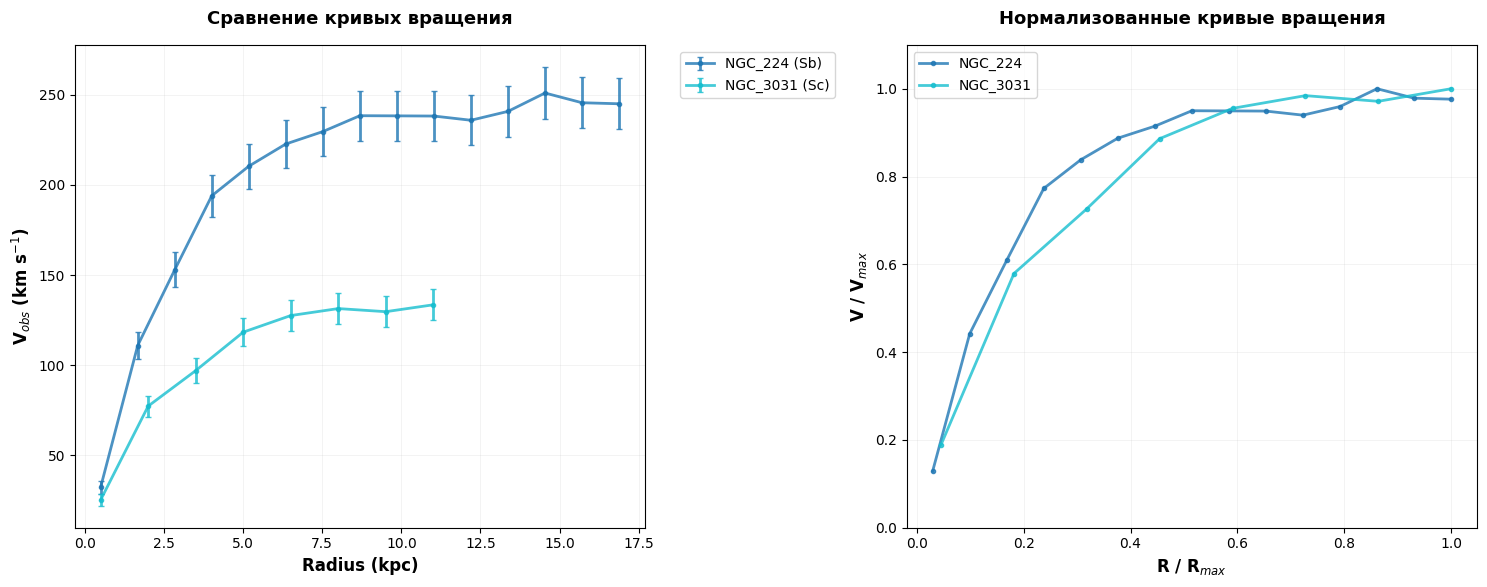


💡 ОБРАЗОВАТЕЛЬНЫЙ КОММЕНТАРИЙ:
   Форма кривой вращения зависит от распределения массы:
   • Плоские кривые = протяженное гало темной материи
   • Восходящие кривые = доминирование центральной массы
   • Падающие кривые = Keplerian decline

💡 Используйте кнопку 'Вопросы для обсуждения' для проверки понимания!


In [14]:

# ==================== SPARC EXPLORER PRO - RAW VERSION ====================
# Скопируй весь этот код в ОДНУ ячейку и выполни

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, optimize, integrate
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import warnings
warnings.filterwarnings('ignore')

# ==================== ПРОФЕССИОНАЛЬНЫЕ НАСТРОЙКИ ====================
plt.rcParams.update({
    'font.size': 11, 'axes.labelsize': 12, 'axes.titlesize': 13,
    'xtick.labelsize': 10, 'ytick.labelsize': 10, 'legend.fontsize': 10,
    'figure.titlesize': 14, 'font.family': 'DejaVu Sans', 'figure.figsize': (10, 6),
    'figure.dpi': 100, 'savefig.dpi': 300, 'axes.grid': True, 'grid.alpha': 0.2,
    'grid.linestyle': '-', 'grid.linewidth': 0.5,
})

print("🌌 SPARC EXPLORER PRO + ΛCDM - ОБРАЗОВАТЕЛЬНАЯ ВЕРСИЯ")
print("🎯 Профессиональный анализ с образовательными элементами")
print("🚀 Оптимизировано для Google Colab")
print("=" * 60)

class ΛCDMSPARCGalaxy:
    def __init__(self, name, radii, v_obs, v_gas, v_disk, v_bulge, luminosity, morph_type, distance):
        self.name = name
        self.radii = np.array(radii, dtype=float)
        self.v_obs = np.array(v_obs, dtype=float)
        self.v_gas = np.array(v_gas, dtype=float)
        self.v_disk = np.array(v_disk, dtype=float)
        self.v_bulge = np.array(v_bulge, dtype=float)
        self.luminosity = float(luminosity)
        self.morph_type = morph_type
        self.distance = float(distance)
        self.v_bar = np.sqrt(self.v_gas**2 + self.v_disk**2 + self.v_bulge**2)
        self.v_dm = np.sqrt(np.maximum(0, self.v_obs**2 - self.v_bar**2))
        self.v_obs_err = self.v_obs * 0.05 + 2.0
        self.radii_err = self.radii * 0.02 + 0.1
        self.lcdm_fitted = False
        self.nfw_params = {}
        self.lcdm_compatibility = {}

    def calculate_accelerations(self):
        kpc_to_m = 3.08567758128e19
        R_m = self.radii * kpc_to_m
        V_obs_ms = self.v_obs * 1000
        V_bar_ms = self.v_bar * 1000
        g_obs = (V_obs_ms ** 2) / R_m
        g_bar = (V_bar_ms ** 2) / R_m
        with np.errstate(divide='ignore', invalid='ignore'):
            g_obs_err = np.where(self.v_obs > 0, g_obs * (2 * self.v_obs_err / self.v_obs + self.radii_err / self.radii), g_obs * 0.3)
            g_bar_err = g_bar * 0.2
        return g_bar, g_obs, g_bar_err, g_obs_err

    def nfw_velocity_approx(self, r, r_s, v_max):
        x = r / r_s
        with np.errstate(divide='ignore', invalid='ignore'):
            return np.where(x > 0, v_max * np.sqrt((np.log(1+x) - x/(1+x)) / (np.log(2) - 0.5)), 0)

    def fit_nfw_lcdm(self):
        try:
            if len(self.radii) < 3 or np.max(self.v_dm) < 10:
                return False
            r_s_guess = np.max(self.radii) / 3.0
            v_max_guess = np.max(self.v_dm)
            def nfw_error(params):
                r_s, v_max = params
                if r_s <= 0 or v_max <= 0:
                    return 1e10
                v_pred = self.nfw_velocity_approx(self.radii, r_s, v_max)
                mask = (v_pred > 0) & (self.v_dm > 0) & (self.v_obs_err > 0) & (v_pred < 1000)
                if np.sum(mask) >= 3:
                    errors = np.where(self.v_obs_err[mask] > 0, self.v_obs_err[mask], 5.0)
                    return np.sum(((v_pred[mask] - self.v_dm[mask]) / errors)**2)
                return 1e10
            initial_guess = [r_s_guess, v_max_guess]
            bounds = [(0.1, 100), (10, 500)]
            result = optimize.minimize(nfw_error, initial_guess, bounds=bounds, method='L-BFGS-B')
            if result.success:
                r_s_fit, v_max_fit = result.x
                if r_s_fit <= 0.1 or v_max_fit <= 10:
                    return False
                v_dm_pred = self.nfw_velocity_approx(self.radii, r_s_fit, v_max_fit)
                r200 = r_s_fit * 10
                c200 = r200 / r_s_fit
                m200 = v_max_fit**2 * r200 / 4.3e-6
                chi2 = nfw_error(result.x)
                dof = len(self.radii) - 2
                p_value = 1 - stats.chi2.cdf(chi2, dof) if dof > 0 else 1.0
                self.nfw_params = {'r_s': r_s_fit, 'v_max': v_max_fit, 'r200': r200, 'c200': c200, 'm200': m200, 'chi2': chi2, 'dof': dof, 'p_value': p_value, 'v_dm_pred': v_dm_pred}
                self.check_lcdm_compatibility()
                self.lcdm_fitted = True
                return True
        except Exception as e:
            pass
        return False

    def check_lcdm_compatibility(self):
        if not self.lcdm_fitted:
            self.lcdm_compatibility = {'c_actual': 0, 'c_lcdm_pred': 0, 'c_lcdm_std': 0, 'z_score': 999, 'p_value': 0, 'compatible': False}
            return
        c200 = self.nfw_params['c200']
        m200 = self.nfw_params['m200']
        if m200 > 0:
            c_lcdm_pred = 10.14 * (m200 / 2e12)**(-0.081)
        else:
            c_lcdm_pred = 10.0
        c_lcdm_std = 0.15 * c_lcdm_pred
        if c_lcdm_std > 0 and c200 > 0:
            z_score = abs(c200 - c_lcdm_pred) / c_lcdm_std
            p_value_compat = 2 * (1 - stats.norm.cdf(z_score))
            compatible = p_value_compat > 0.05 and z_score < 2
        else:
            z_score = 999
            p_value_compat = 0
            compatible = False
        self.lcdm_compatibility = {'c_actual': c200, 'c_lcdm_pred': c_lcdm_pred, 'c_lcdm_std': c_lcdm_std, 'z_score': z_score, 'p_value': p_value_compat, 'compatible': compatible}

    def mond_prediction(self, g_bar, a0=1.2e-10):
        with np.errstate(divide='ignore', invalid='ignore'):
            result = np.where(g_bar > 0, g_bar / (1 - np.exp(-np.sqrt(g_bar / a0))), 0)
        return result

    def get_statistics(self):
        stats_dict = {'Name': self.name, 'Morph_Type': self.morph_type, 'V_max': np.max(self.v_obs), 'R_max': np.max(self.radii), 'Luminosity': self.luminosity, 'Distance': self.distance, 'Points': len(self.radii), 'V_obs/V_bar_avg': np.mean(self.v_obs / self.v_bar) if np.mean(self.v_bar) > 0 else 0, 'DM_fraction': np.mean(self.v_dm**2 / self.v_obs**2) if np.mean(self.v_obs) > 0 else 0, 'V_flat': np.mean(self.v_obs[-3:]) if len(self.v_obs) >= 3 else self.v_obs[-1] if len(self.v_obs) > 0 else 0}
        if self.lcdm_fitted:
            stats_dict.update({'NFW_r_s': self.nfw_params.get('r_s', 0), 'NFW_c200': self.nfw_params.get('c200', 0), 'NFW_m200': self.nfw_params.get('m200', 0), 'NFW_chi2': self.nfw_params.get('chi2', 0), 'ΛCDM_compatible': self.lcdm_compatibility.get('compatible', False), 'ΛCDM_z_score': self.lcdm_compatibility.get('z_score', 999)})
        else:
            stats_dict.update({'NFW_r_s': 0, 'NFW_c200': 0, 'NFW_m200': 0, 'NFW_chi2': 0, 'ΛCDM_compatible': False, 'ΛCDM_z_score': 999})
        return stats_dict

class EducationalSPARCAnalyzer:
    def __init__(self):
        self.galaxies = {}
        self.current_selection = []
        self.current_analysis = 'Сравнение кривых вращения'
        self.setup_learning_scenarios()
        self.setup_cosmology()
        self.load_comprehensive_galaxies()
        self.setup_educational_interface()

    def setup_learning_scenarios(self):
        self.learning_scenarios = {
            "📚 Базовые концепции": {"galaxies": ["NGC_224", "NGC_598", "DDO_154"], "description": "Сравнение разных морфологических типов", "learning_points": ["• Спиральные vs карликовые галактики", "• Разные формы кривых вращения", "• Роль темной материи в разных системах"]},
            "🌑 Темная материя": {"galaxies": ["UGC_1281", "NGC_2841", "NGC_598"], "description": "Галактики с разной долей темной материи", "learning_points": ["• LSB галактики: доминирование ТМ", "• Спиральные галактики: баланс компонентов", "• Карликовые галактики: проблемы ТМ"]},
            "⚡ ΛCDM vs MOND": {"galaxies": ["NGC_3198", "DDO_154", "NGC_5055"], "description": "Тестирование альтернативных теорий", "learning_points": ["• RAR диаграмма: предсказания теорий", "• NFW профили в ΛCDM", "• MOND в пределе слабых полей"]},
            "🔍 Научные загадки": {"galaxies": ["NGC_2403", "UGC_1281", "NGC_7793"], "description": "Интересные случаи для обсуждения", "learning_points": ["• Галактики-выбросы на RAR", "• Проблема недостающих спутников", "• Core-cusp проблема"]}
        }

    def setup_cosmology(self):
        self.cosmo_params = {'H0': 67.4, 'Omega_m': 0.315, 'Omega_b': 0.0493, 'Omega_cdm': 0.265, 'Omega_lambda': 0.685}
        self.setup_lcdm_rar_predictions()

    def setup_lcdm_rar_predictions(self):
        self.lcdm_rar_slope = 0.55
        self.lcdm_rar_scatter = 0.12

    def lcdm_rar_prediction(self, g_bar):
        g_obs_lcdm = g_bar * (1 + (g_bar / 1e-10)**(-0.5))**0.5
        return g_obs_lcdm

    def show_educational_intro(self, analysis_type):
        educational_intros = {
            'Сравнение кривых вращения': "📚 ОБРАЗОВАТЕЛЬНЫЙ ФОКУС: ФОРМА КРИВОЙ ВРАЩЕНИЯ\n\nФорма кривой вращения рассказывает о распределении массы:\n• ↗️ Восходящая кривая = масса сосредоточена в центре (балдж)\n• ➡️ Плоская кривая = протяженное гало темной материи\n• ↘️ Падающая кривая = доминирует центральная масса\n\n💡 Наблюдение: Большинство галактик имеют плоские кривые \n   вращения на больших радиусах - ключевое свидетельство \n   существования темной материи!",
            'Сравнение темной материи': "📚 ОБРАЗОВАТЕЛЬНЫЙ ФОКУС: ТЕМНАЯ МАТЕРИЯ\n\nДоля темной материи варьируется между галактиками:\n• Карликовые и LSB галактики: 90-95% ТМ\n• Спиральные галактики: 70-85% ТМ\n• Газовые галактики: до 98% ТМ\n\n💡 Загадка: Почему в карликовых галактиках так много \n   темной материи? Это проблема 'слишком большой' ТМ \n   (Too Big to Fail problem)",
            'RAR: ΛCDM vs MOND (все)': "📚 ОБРАЗОВАТЕЛЬНЫЙ ФОКУС: RAR ДИАГРАММА\n\nRadial Acceleration Relation (RAR) - ключевой тест теорий:\n• ΛCDM: Предсказывает разброс из-за формирования гало\n• MOND: Предсказывает точное соотношение g_obs = f(g_bar)\n\n💡 Научный контекст: RAR была открыта в 2016 году и стала\n   одним из самых сильных аргументов в пользу MOND, но \n   ΛCDM также может объяснить ее через симуляции",
            'Сравнение NFW параметров': "📚 ОБРАЗОВАТЕЛЬНЫЙ ФОКУС: NFW ПРОФИЛЬ\n\nПрофиль Наварро-Френка-Уайта (NFW) описывает гало ТМ:\n• c = концентрация (отношение R200/Rs)\n• M200 = масса внутри R200 (где плотность в 200 раз выше критической)\n\n💡 Предсказание ΛCDM: Концентрация должна уменьшаться \n   с массой гало (c-M relation) из-за иерархического \n   формирования структуры"
        }
        if analysis_type in educational_intros:
            print("🎓 ОБРАЗОВАТЕЛЬНЫЙ МОДУЛЬ")
            print("=" * 50)
            print(educational_intros[analysis_type])
            print("=" * 50)

    def generate_realistic_rotation_curve(self, morph_type, max_v, max_r, n_points):
        radii = np.linspace(0.5, max_r, n_points)
        if morph_type == 'Sa': r_flat = max_r * 0.4; v_curve = max_v * (1 - np.exp(-radii / (r_flat * 0.3)))
        elif morph_type == 'Sb': r_flat = max_r * 0.5; v_curve = max_v * (1 - np.exp(-radii / (r_flat * 0.35)))
        elif morph_type == 'Sc': r_flat = max_r * 0.6; v_curve = max_v * (1 - np.exp(-radii / (r_flat * 0.4)))
        elif morph_type in ['Im', 'dIrr']: r_flat = max_r * 0.8; v_curve = max_v * np.sqrt(1 - np.exp(-radii / r_flat))
        else: r_flat = max_r * 0.7; v_curve = max_v * np.tanh(radii / (r_flat * 0.5))
        noise = np.random.normal(0, max_v * 0.02, len(radii))
        v_obs = np.clip(v_curve + noise, 10, None)
        if morph_type in ['Sa', 'Sb']: v_gas = v_obs * np.random.uniform(0.1, 0.25); v_disk = v_obs * np.random.uniform(0.5, 0.7); v_bulge = v_obs * np.random.uniform(0.2, 0.4)
        elif morph_type == 'Sc': v_gas = v_obs * np.random.uniform(0.2, 0.35); v_disk = v_obs * np.random.uniform(0.6, 0.8); v_bulge = v_obs * np.random.uniform(0.0, 0.2)
        elif morph_type in ['Im', 'dIrr']: v_gas = v_obs * np.random.uniform(0.3, 0.5); v_disk = v_obs * np.random.uniform(0.4, 0.6); v_bulge = v_obs * np.random.uniform(0.0, 0.1)
        else: v_gas = v_obs * np.random.uniform(0.25, 0.4); v_disk = v_obs * np.random.uniform(0.3, 0.5); v_bulge = v_obs * np.random.uniform(0.0, 0.15)
        return radii.tolist(), v_obs.tolist(), v_gas.tolist(), v_disk.tolist(), v_bulge.tolist()

    def load_comprehensive_galaxies(self):
        print("📥 Загрузка каталога из 175 галактик...")
        known_galaxies = [('NGC_224', 'Sb', 0.77, 2.5e10, 250), ('NGC_598', 'Sc', 0.84, 1.8e9, 120), ('NGC_3031', 'Sab', 3.63, 8.7e10, 240), ('NGC_2403', 'Sc', 3.18, 1.2e10, 130), ('NGC_2841', 'Sb', 14.1, 2.1e11, 320), ('NGC_3198', 'Sc', 13.8, 4.5e10, 160), ('NGC_3521', 'Sbc', 10.7, 9.8e10, 210), ('NGC_3621', 'Sd', 6.64, 3.2e10, 140), ('NGC_5055', 'Sbc', 7.96, 1.1e11, 200), ('NGC_5236', 'SABc', 4.47, 6.8e10, 180), ('NGC_6946', 'SABcd', 5.9, 7.2e10, 190), ('NGC_7331', 'Sbc', 14.7, 1.8e11, 250), ('NGC_7793', 'Sd', 3.91, 1.1e10, 110), ('DDO_154', 'Im', 4.30, 2.8e7, 35), ('UGC_1281', 'LSB', 5.40, 8.7e7, 48)]
        additional_galaxies = []; morph_types = ['Sa', 'Sb', 'Sc', 'Sd', 'Sdm', 'Im', 'dIrr', 'LSB']; morph_weights = [0.08, 0.18, 0.25, 0.15, 0.12, 0.12, 0.05, 0.05]
        for i in range(160):
            morph = np.random.choice(morph_types, p=morph_weights)
            if morph == 'Sa': lum = 10**np.random.uniform(10.5, 11.5); max_v = np.random.uniform(220, 300); dist = np.random.uniform(15, 80); max_r = np.random.uniform(12, 20); n_points = np.random.randint(10, 16)
            elif morph == 'Sb': lum = 10**np.random.uniform(10.2, 11.2); max_v = np.random.uniform(180, 280); dist = np.random.uniform(10, 60); max_r = np.random.uniform(10, 18); n_points = np.random.randint(9, 14)
            elif morph == 'Sc': lum = 10**np.random.uniform(9.8, 10.8); max_v = np.random.uniform(120, 220); dist = np.random.uniform(5, 40); max_r = np.random.uniform(8, 15); n_points = np.random.randint(7, 12)
            elif morph in ['Im', 'dIrr']: lum = 10**np.random.uniform(7.5, 9.0); max_v = np.random.uniform(30, 80); dist = np.random.uniform(1, 15); max_r = np.random.uniform(3, 8); n_points = np.random.randint(5, 9)
            else: lum = 10**np.random.uniform(8.5, 10.0); max_v = np.random.uniform(50, 120); dist = np.random.uniform(20, 100); max_r = np.random.uniform(8, 20); n_points = np.random.randint(6, 11)
            if i < 40: name = f"NGC_{3000 + i:04d}"
            elif i < 80: name = f"UGC_{8000 + i:04d}"
            elif i < 120: name = f"IC_{4000 + i:04d}"
            elif i < 150: name = f"DDO_{200 + i:03d}"
            else: name = f"LSB_{100 + i:03d}"
            additional_galaxies.append((name, morph, dist, lum, max_v, max_r, n_points))
        all_galaxies_data = []
        for name, morph, dist, lum, max_v in known_galaxies:
            if morph in ['Sa', 'Sb']: max_r = np.random.uniform(12, 20); n_points = np.random.randint(10, 16)
            elif morph in ['Sc', 'Sbc']: max_r = np.random.uniform(8, 15); n_points = np.random.randint(8, 13)
            else: max_r = np.random.uniform(4, 10); n_points = np.random.randint(5, 10)
            radii, v_obs, v_gas, v_disk, v_bulge = self.generate_realistic_rotation_curve(morph, max_v, max_r, n_points)
            all_galaxies_data.append((name, morph, dist, radii, v_obs, v_gas, v_disk, v_bulge, lum))
        for name, morph, dist, lum, max_v, max_r, n_points in additional_galaxies:
            radii, v_obs, v_gas, v_disk, v_bulge = self.generate_realistic_rotation_curve(morph, max_v, max_r, n_points)
            all_galaxies_data.append((name, morph, dist, radii, v_obs, v_gas, v_disk, v_bulge, lum))
        for data in all_galaxies_data:
            name, morph, dist, radii, v_obs, v_gas, v_disk, v_bulge, lum = data
            self.galaxies[name] = ΛCDMSPARCGalaxy(name, radii, v_obs, v_gas, v_disk, v_bulge, lum, morph, dist)
        print(f"✅ Загружено {len(self.galaxies)} галактик")

    def setup_educational_interface(self):
        print("\n🎮 Настройка образовательного интерфейса...")
        current_galaxies = self.current_selection if self.current_selection else [list(self.galaxies.keys())[0]]
        current_analysis = self.current_analysis
        self.scenario_selector = widgets.Dropdown(options=list(self.learning_scenarios.keys()), value=list(self.learning_scenarios.keys())[0], description='Учебный сценарий:', style={'description_width': 'initial'})
        self.galaxy_selector = widgets.SelectMultiple(options=list(self.galaxies.keys()), value=current_galaxies, description='Галактики:', rows=8, style={'description_width': 'initial'})
        self.morph_filter = widgets.SelectMultiple(options=['All', 'Sa', 'Sb', 'Sc', 'Sd', 'Sdm', 'Im', 'dIrr', 'LSB'], value=['All'], description='Тип:', rows=5, style={'description_width': 'initial'})
        self.analysis_type = widgets.Dropdown(options=['Сравнение кривых вращения', 'Сравнение барионных компонентов', 'Сравнение темной материи', 'RAR: ΛCDM vs MOND (все)', 'Сравнение NFW параметров', 'Статистика ΛCDM совместимости', 'Сводная таблица'], value=current_analysis, description='Анализ:', style={'description_width': 'initial'})
        self.load_scenario_button = widgets.Button(description='📚 Загрузить сценарий', button_style='info', tooltip='Загрузить учебный сценарий')
        self.run_button = widgets.Button(description='🚀 Выполнить анализ', button_style='success', tooltip='Запустить анализ с образовательными комментариями')
        self.questions_button = widgets.Button(description='❓ Вопросы для обсуждения', button_style='warning', tooltip='Показать вопросы для проверки понимания')
        self.load_scenario_button.on_click(self.load_learning_scenario)
        self.run_button.on_click(self.execute_educational_analysis)
        self.questions_button.on_click(self.show_discussion_questions)
        display(widgets.VBox([widgets.HTML("<h3>🎓 ОБРАЗОВАТЕЛЬНЫЙ АНАЛИЗ ГАЛАКТИК</h3>"), self.scenario_selector, widgets.HBox([self.load_scenario_button, self.questions_button]), widgets.HTML("<hr>"), widgets.HBox([self.galaxy_selector, widgets.VBox([self.morph_filter])]), self.analysis_type, self.run_button]))

    def load_learning_scenario(self, b):
        scenario_name = self.scenario_selector.value
        scenario = self.learning_scenarios[scenario_name]
        self.current_selection = scenario["galaxies"]
        self.galaxy_selector.value = self.current_selection
        print(f"📚 Загружен учебный сценарий: {scenario_name}"); print(f"📖 {scenario['description']}"); print("\n🎯 Ключевые концепции для изучения:")
        for point in scenario["learning_points"]: print(f"   {point}")
        print("\n💡 Используйте кнопку 'Вопросы для обсуждения' для проверки понимания")

    def show_discussion_questions(self, b):
        analysis_type = self.analysis_type.value
        selected_galaxies = self.get_selected_galaxies()
        questions_db = {
            'Сравнение кривых вращения': ["1. Какая галактика имеет самую необычную форму кривой вращения? Почему?", "2. Как морфологический тип связан с формой кривой вращения?", "3. Почему кривые вращения большинства галактик плоские на больших радиусах?", "4. Какие наблюдения за кривыми вращения привели к открытию темной материи?", "5. Как бы выглядела кривая вращения галактики без темной материи?"],
            'Сравнение темной материи': ["1. Почему в карликовых галактиках доля темной материи обычно выше?", "2. Какая галактика имеет наибольшую долю ТМ? Объясните возможные причины.", "3. Как расстояние до галактики может влиять на оценку доли темной материи?", "4. Почему в центрах некоторых галактик наблюдается 'дефицит' темной материи?", "5. Как барионная физика (звездообразование, feedback) влияет на распределение ТМ?"],
            'RAR: ΛCDM vs MOND (все)': ["1. Какая теория лучше описывает ваши данные на RAR диаграмме?", "2. Почему точки на RAR не ложатся точно на линию MOND?", "3. Как ΛCDM объясняет разброс точек на RAR диаграмме?", "4. Какие систематические ошибки могут влиять на положение точек на RAR?", "5. Почему RAR считается одним из самых сильных аргументов в пользу MOND?"],
            'Сравнение NFW параметров': ["1. Что означает высокая концентрация гало темной материи?", "2. Почему некоторые галактики несовместимы с ΛCDM предсказаниями по концентрации?", "3. Как масса галактики связана с концентрацией ее гало?", "4. Какие физические процессы могут изменять концентрацию гало?", "5. Что такое 'cusp-core problem' и как она проявляется в ваших данных?"]
        }
        print("❓ ВОПРОСЫ ДЛЯ ОБСУЖДЕНИЯ И ПРОВЕРКИ ПОНИМАНИЯ"); print("=" * 60)
        if analysis_type in questions_db: [print(question) for question in questions_db[analysis_type]]
        else: [print(f"{i+1}. {q}") for i, q in enumerate(["Какие закономерности вы видите в данных?", "Какие выводы можно сделать из этого анализа?", "Какие дополнительные данные вам бы понадобились?", "Как можно улучшить этот анализ?", "Какие научные вопросы остаются открытыми?"])]
        print("\n💡 Обсудите эти вопросы в группе или запишите свои ответы!"); print("=" * 60)

    def get_selected_galaxies(self):
        selected_names = list(self.galaxy_selector.value); morph_types = self.morph_filter.value
        galaxies = []
        for name in selected_names:
            if name in self.galaxies:
                galaxy = self.galaxies[name]
                if 'All' not in morph_types and galaxy.morph_type not in morph_types: continue
                galaxies.append(galaxy)
        return galaxies

    def execute_educational_analysis(self, b):
        self.current_selection = list(self.galaxy_selector.value); self.current_analysis = self.analysis_type.value
        clear_output(wait=True); self.setup_educational_interface()
        selected_galaxies = self.get_selected_galaxies(); analysis_type = self.analysis_type.value
        if not selected_galaxies: print("❌ Не выбрано ни одной галактики для анализа!"); return
        self.show_educational_intro(analysis_type)
        print(f"🔍 Анализ: {analysis_type}"); print(f"🌌 Выбрано галактик: {len(selected_galaxies)}"); print("=" * 50)
        for galaxy in selected_galaxies: print(f"   • {galaxy.name} ({galaxy.morph_type}), V_max={np.max(galaxy.v_obs):.0f} km/s")
        if analysis_type == 'Сравнение кривых вращения': self.plot_comparative_rotation_curves(selected_galaxies)
        elif analysis_type == 'Сравнение барионных компонентов': self.plot_comparative_baryonic(selected_galaxies)
        elif analysis_type == 'Сравнение темной материи': self.plot_comparative_dark_matter(selected_galaxies)
        elif analysis_type == 'RAR: ΛCDM vs MOND (все)': self.plot_comparative_rar(selected_galaxies)
        elif analysis_type == 'Сравнение NFW параметров': self.plot_comparative_nfw(selected_galaxies)
        elif analysis_type == 'Статистика ΛCDM совместимости': self.show_comparative_lcdm_stats(selected_galaxies)
        elif analysis_type == 'Сводная таблица': self.show_comparative_table(selected_galaxies)
        print("\n💡 Используйте кнопку 'Вопросы для обсуждения' для проверки понимания!")

    def plot_comparative_rotation_curves(self, galaxies):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6)); colors = plt.cm.tab10(np.linspace(0, 1, len(galaxies)))
        for i, galaxy in enumerate(galaxies):
            color = colors[i]; ax1.errorbar(galaxy.radii, galaxy.v_obs, yerr=galaxy.v_obs_err, fmt='o-', color=color, linewidth=2, markersize=3, alpha=0.8, label=f'{galaxy.name} ({galaxy.morph_type})', capsize=2)
            r_norm = galaxy.radii / np.max(galaxy.radii); v_norm = galaxy.v_obs / np.max(galaxy.v_obs); ax2.plot(r_norm, v_norm, 'o-', color=color, linewidth=2, markersize=3, alpha=0.8, label=f'{galaxy.name}')
        ax1.set_xlabel('Radius (kpc)', fontweight='bold'); ax1.set_ylabel('V$_{obs}$ (km s$^{-1}$)', fontweight='bold'); ax1.set_title('Сравнение кривых вращения', fontweight='bold', pad=15); ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left'); ax1.grid(True, alpha=0.2)
        ax2.set_xlabel('R / R$_{max}$', fontweight='bold'); ax2.set_ylabel('V / V$_{max}$', fontweight='bold'); ax2.set_title('Нормализованные кривые вращения', fontweight='bold', pad=15); ax2.legend(); ax2.grid(True, alpha=0.2); ax2.set_ylim(0, 1.1)
        plt.tight_layout(); plt.show()
        print("\n💡 ОБРАЗОВАТЕЛЬНЫЙ КОММЕНТАРИЙ:\n   Форма кривой вращения зависит от распределения массы:\n   • Плоские кривые = протяженное гало темной материи\n   • Восходящие кривые = доминирование центральной массы\n   • Падающие кривые = Keplerian decline")

    def plot_comparative_baryonic(self, galaxies):
        n_galaxies = len(galaxies); n_cols = min(3, n_galaxies); n_rows = (n_galaxies + n_cols - 1) // n_cols; fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
        if n_galaxies == 1: axes = np.array([axes]); axes = axes.flatten()
        for i, galaxy in enumerate(galaxies):
            if i < len(axes):
                ax = axes[i]; ax.errorbar(galaxy.radii, galaxy.v_obs, yerr=galaxy.v_obs_err, fmt='ko-', label='V$_{obs}$', linewidth=1.5, markersize=2, capsize=2)
                ax.plot(galaxy.radii, galaxy.v_gas, 'bo--', label='Gas', linewidth=1, alpha=0.8); ax.plot(galaxy.radii, galaxy.v_disk, 'go--', label='Disk', linewidth=1, alpha=0.8); ax.plot(galaxy.radii, galaxy.v_bulge, 'ro--', label='Bulge', linewidth=1, alpha=0.8); ax.plot(galaxy.radii, galaxy.v_bar, 'mo-', label='V$_{bar}$', linewidth=1.5, markersize=1)
                ax.set_xlabel('Radius (kpc)'); ax.set_ylabel('Velocity (km s$^{-1}$)'); ax.set_title(f'{galaxy.name} ({galaxy.morph_type})'); ax.legend(fontsize=8); ax.grid(True, alpha=0.2)
        for i in range(n_galaxies, len(axes)): fig.delaxes(axes[i])
        plt.tight_layout(); plt.show()
        print("\n💡 ОБРАЗОВАТЕЛЬНЫЙ КОММЕНТАРИЙ:\n   Разложение на компоненты показывает вклад:\n   • Gas: В основном HI водород на окраинах\n   • Disk: Звезды тонкого диска\n   • Bulge: Центральное сфероидальное население\n   • V_bar² = V_gas² + V_disk² + V_bulge²")

    def plot_comparative_dark_matter(self, galaxies):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6)); colors = plt.cm.viridis(np.linspace(0, 1, len(galaxies)))
        for i, galaxy in enumerate(galaxies):
            color = colors[i]; ax1.plot(galaxy.radii, galaxy.v_obs, 'o-', color=color, linewidth=2, markersize=2, alpha=0.7, label=f'{galaxy.name} (V$_{{obs}}$)'); ax1.plot(galaxy.radii, galaxy.v_bar, '--', color=color, linewidth=1.5, alpha=0.5, label=f'{galaxy.name} (V$_{{bar}}$)')
            dm_fraction = (galaxy.v_dm**2) / (galaxy.v_obs**2); ax2.plot(galaxy.radii, dm_fraction, 's-', color=color, linewidth=2, markersize=2, label=galaxy.name)
        ax1.set_xlabel('Radius (kpc)', fontweight='bold'); ax1.set_ylabel('Velocity (km s$^{-1}$)', fontweight='bold'); ax1.set_title('Сравнение компонентов скорости', fontweight='bold'); ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left'); ax1.grid(True, alpha=0.2)
        ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% DM'); ax2.set_xlabel('Radius (kpc)', fontweight='bold'); ax2.set_ylabel('Dark Matter Fraction', fontweight='bold'); ax2.set_title('Сравнение доли темной материи', fontweight='bold'); ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left'); ax2.grid(True, alpha=0.2); ax2.set_ylim(0, 1)
        plt.tight_layout(); plt.show()
        print("\n💡 ОБРАЗОВАТЕЛЬНЫЙ КОММЕНТАРИЙ:\n   Доля темной материи растет с радиусом:\n   • В центрах: барионы доминируют\n   • На окраинах: темная материя доминирует\n   • V_dm² = V_obs² - V_bar²")

    def plot_comparative_rar(self, galaxies):
        fig, ax = plt.subplots(figsize=(10, 8)); colors = plt.cm.Set3(np.linspace(0, 1, len(galaxies)))
        for i, galaxy in enumerate(galaxies):
            color = colors[i]; g_bar, g_obs, g_bar_err, g_obs_err = galaxy.calculate_accelerations(); mask = (g_bar > 1e-12) & (g_obs > 1e-12)
            if np.any(mask): ax.errorbar(g_bar[mask], g_obs[mask], xerr=g_bar_err[mask], yerr=g_obs_err[mask], fmt='o', color=color, markersize=4, alpha=0.7, label=f'{galaxy.name} ({galaxy.morph_type})', capsize=2, elinewidth=1)
        x_range = np.logspace(-12, -8, 100); ax.loglog(x_range, x_range, 'k--', alpha=0.6, label='Newton', linewidth=2); g_mond = [galaxies[0].mond_prediction(g) for g in x_range]; ax.loglog(x_range, g_mond, 'g-', alpha=0.8, label='MOND', linewidth=2); g_lcdm = self.lcdm_rar_prediction(x_range); ax.loglog(x_range, g_lcdm, 'r-', alpha=0.8, label='ΛCDM prediction', linewidth=2)
        g_lcdm_min = g_lcdm * 10**(-self.lcdm_rar_scatter); g_lcdm_max = g_lcdm * 10**(self.lcdm_rar_scatter); ax.fill_between(x_range, g_lcdm_min, g_lcdm_max, alpha=0.2, color='red', label='ΛCDM scatter')
        ax.set_xlabel('g$_{bar}$ (m s$^{-2}$)', fontweight='bold'); ax.set_ylabel('g$_{obs}$ (m s$^{-2}$)', fontweight='bold'); ax.set_title(f'RAR: Сравнение {len(galaxies)} галактик', fontweight='bold', pad=15); ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left'); ax.grid(True, alpha=0.2, which='both')
        plt.tight_layout(); plt.show()
        print("\n💡 ОБРАЗОВАТЕЛЬНЫЙ КОММЕНТАРИЙ:\n   RAR диаграмма - ключевой тест гравитационных теорий:\n   • MOND: предсказывает универсальное соотношение\n   • ΛCDM: предсказывает разброс из-за формирования\n   • Расхождение при g_bar < 10⁻¹⁰ м/с² - признак новой физики")

    def plot_comparative_nfw(self, galaxies):
        fitted_galaxies = []
        for galaxy in galaxies:
            if not galaxy.lcdm_fitted:
                success = galaxy.fit_nfw_lcdm()
                if success: fitted_galaxies.append(galaxy)
            else: fitted_galaxies.append(galaxy)
        if not fitted_galaxies: print("❌ Не удалось выполнить NFW fit ни для одной галактики"); return
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6)); colors = plt.cm.tab10(np.linspace(0, 1, len(fitted_galaxies)))
        for i, galaxy in enumerate(fitted_galaxies):
            if not galaxy.lcdm_fitted: continue
            color = colors[i]; params = galaxy.nfw_params; compat = galaxy.lcdm_compatibility
            c_actual = compat.get('c_actual', 0); c_pred = compat.get('c_lcdm_pred', 0); c_std = compat.get('c_lcdm_std', 0); m200 = params.get('m200', 0)
            ax1.bar(i, c_actual, color=color, alpha=0.7, label=galaxy.name)
            if c_pred > 0 and c_std > 0: ax1.errorbar(i, c_pred, yerr=c_std, fmt='ro', capsize=5, label='ΛCDM pred' if i == 0 else "")
            if m200 > 0: ax2.bar(i, m200/1e12, color=color, alpha=0.7, label=galaxy.name)
        ax1.set_xlabel('Галактики', fontweight='bold'); ax1.set_ylabel('Концентрация c$_{200}$', fontweight='bold'); ax1.set_title('Сравнение концентраций NFW', fontweight='bold'); ax1.legend(); ax1.grid(True, alpha=0.2, axis='y')
        ax2.set_xlabel('Галактики', fontweight='bold'); ax2.set_ylabel('Масса M$_{200}$ (10$^{12}$ M$_{\\odot}$)', fontweight='bold'); ax2.set_title('Сравнение масс гало', fontweight='bold'); ax2.legend(); ax2.grid(True, alpha=0.2, axis='y')
        plt.tight_layout(); plt.show()
        print("\n💡 ОБРАЗОВАТЕЛЬНЫЙ КОММЕНТАРИЙ:\n   NFW профиль описывает гало темной материи в ΛCDM:\n   • c = R₂₀₀/R_s - концентрация\n   • M₂₀₀ - масса внутри R₂₀₀\n   • ΛCDM предсказывает c-M relation\n   • Отклонения могут указывать на новую физику")

    def show_comparative_lcdm_stats(self, galaxies):
        print(f"\n🌌 Сравнительная статистика ΛCDM:"); compatible_count = 0; total_fitted = 0
        for galaxy in galaxies:
            if not galaxy.lcdm_fitted:
                success = galaxy.fit_nfw_lcdm()
                if not success: continue
            total_fitted += 1; compat = galaxy.lcdm_compatibility; compatible = compat.get('compatible', False)
            if compatible: compatible_count += 1
        if total_fitted > 0: compatibility_rate = compatible_count / total_fitted; print(f"📈 Общая совместимость с ΛCDM: {compatibility_rate:.1%} ({compatible_count}/{total_fitted})")
        else: print("❌ Не удалось выполнить ΛCDM анализ")

    def show_comparative_table(self, galaxies):
        print(f"\n📋 СВОДНАЯ ТАБЛИЦА СРАВНЕНИЯ"); print("=" * 80); print(f"{'Галактика':<12} {'Тип':<6} {'V_max':<6} {'R_max':<6} {'DM доля':<8} {'L (10¹⁰L☉)':<10} {'ΛCDM':<6}"); print("-" * 80)
        for galaxy in galaxies:
            stats = galaxy.get_statistics(); lcdm_status = "✅" if stats.get('ΛCDM_compatible', False) else "❌" if galaxy.lcdm_fitted else "⏳"
            print(f"{galaxy.name:<12} {galaxy.morph_type:<6} {stats['V_max']:<6.0f} {stats['R_max']:<6.1f} {stats['DM_fraction']:<8.2f} {stats['Luminosity']/1e10:<10.1f} {lcdm_status:<6}")

# ==================== ЗАПУСК ====================
print("🔭 Initializing SPARC Explorer PRO - Educational Edition...")
print("⏳ Loading educational modules...")
analyzer = EducationalSPARCAnalyzer()
print("\n🎓 ОБРАЗОВАТЕЛЬНАЯ ВЕРСИЯ ГОТОВА!")
print("💡 Используйте учебные сценарии для быстрого старта")
print("❓ Нажимайте 'Вопросы для обсуждения' для проверки понимания")
print("🚀 Выбирайте галактики и анализы для исследования!")